# MODELING
In this notebook, I will be implementing machine learning models using Sci-kit Learn in order to try to predict our target variable of classifying a fire as small (<1 acre) or large (>=1 acre). We will import the clean data from a saved csv and run the models on it. The primary goal in this is to optimize and select a model which yields the highest accuracy score on the test set. The reason we are using accuracy as our evaluation metric is because we want to know how well our model can classify a fire as large or small. Things like recall and precision might be useful but are not our primary interest - the concern is not to minimize false positives or false negatives, the goal is to accurately predict when a fire is large or small. 

In [10]:
#import necessary libraries
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#sklearn and xgboost libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid

In [11]:
#read clean data into Pandas DataFrame
df = pd.read_csv('clean_data.csv')
df.head()

,SIZE_BINARY_CLASS,FIRE_SIZE_CLASS,FIRE_SIZE,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,DISCOVERY_TIME_Evening,DISCOVERY_TIME_Midday,DISCOVERY_TIME_Night or Morning,NWCG_CAUSE_CLASSIFICATION_Human,NWCG_CAUSE_CLASSIFICATION_Natural,OWNER_DESCR_Government,OWNER_DESCR_Private,REGION_East,REGION_Midwest,REGION_West
0,Small,A,0.10,2005,33,40.036944,-121.005833,0,1,0,1,0,1,0,0,0,1
1,Small,A,0.25,2004,133,38.933056,-120.404444,0,0,1,0,1,1,0,0,0,1
2,Small,A,0.10,2004,152,38.984167,-120.735556,1,0,0,1,0,0,0,0,0,1
3,Small,A,0.10,2004,180,38.559167,-119.913333,0,1,0,0,1,1,0,0,0,1
4,Small,A,0.10,2004,180,38.559167,-119.933056,0,1,0,0,1,1,0,0,0,1


In [12]:
#check shape
df.shape

(2299932, 17)

#### Checking for multicollinearity
Many models perform more poorly if there is multicollinearity among the features. Because of this, we are going to check for this in our data in order to improve model performance.

In [13]:
#look at columns
df.columns

Index(['SIZE_BINARY_CLASS', 'FIRE_SIZE_CLASS', 'FIRE_SIZE', 'FIRE_YEAR',
       'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_TIME_Evening',
       'DISCOVERY_TIME_Midday', 'DISCOVERY_TIME_Night or Morning',
       'NWCG_CAUSE_CLASSIFICATION_Human', 'NWCG_CAUSE_CLASSIFICATION_Natural',
       'OWNER_DESCR_Government', 'OWNER_DESCR_Private', 'REGION_East',
       'REGION_Midwest', 'REGION_West'],
      dtype='object')

In [14]:
# Split df into features and target variable
X = df[['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_TIME_Evening', \
        'DISCOVERY_TIME_Midday', 'DISCOVERY_TIME_Night or Morning',\
        'NWCG_CAUSE_CLASSIFICATION_Human',\
        'NWCG_CAUSE_CLASSIFICATION_Natural', 'OWNER_DESCR_Government', 'OWNER_DESCR_Private',\
        'REGION_East', 'REGION_Midwest', 'REGION_West']]
y = df['SIZE_BINARY_CLASS']

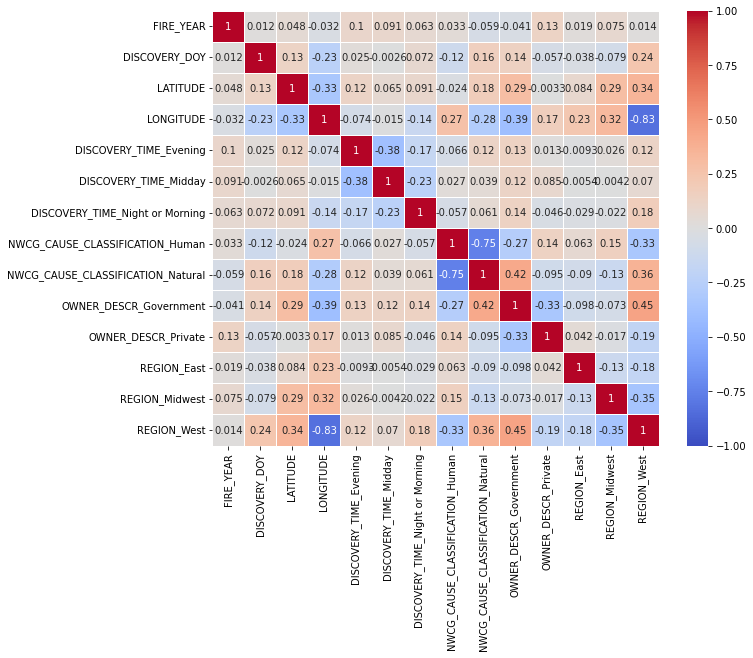

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, lw=1)
plt.show()

The only noteworthy correlatiton between features is that between Longitude and REGION_West. This is unsurprising because we would expect regions in the west to have a more negative longitude. We're going to keep both in and try to mitigate any impact of multicollinearity in our models through methods like dimensionilty reduction or regularization when we build them.

I am going to sample from our dataframe in order to save computation time on some of the more computationally expensive models like K-nearest neighbors and Random Forest. When interpreting our results, it will be important to remember that for these algorithms we used sampled dataframes. This may affect results since there will be less data for the models to interpret.

In [16]:
# Distribution of target variable in original dataframe
df['SIZE_BINARY_CLASS'].value_counts(normalize=True)

Small    0.505635
Large    0.494365
Name: SIZE_BINARY_CLASS, dtype: float64

In [17]:
#sample from dataframe - s for sample
sdf = df.sample(frac=.05, random_state=11)
sdf['SIZE_BINARY_CLASS'].value_counts(normalize=True)

Small    0.505109
Large    0.494891
Name: SIZE_BINARY_CLASS, dtype: float64

In [18]:
sdf.shape

(114997, 17)

In [19]:
# X1 and y1 for samples!
X1 = sdf.drop(['SIZE_BINARY_CLASS', 'FIRE_SIZE_CLASS', 'FIRE_SIZE'], axis=1)
y1 = sdf['SIZE_BINARY_CLASS']
X1.head()

,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,DISCOVERY_TIME_Evening,DISCOVERY_TIME_Midday,DISCOVERY_TIME_Night or Morning,NWCG_CAUSE_CLASSIFICATION_Human,NWCG_CAUSE_CLASSIFICATION_Natural,OWNER_DESCR_Government,OWNER_DESCR_Private,REGION_East,REGION_Midwest,REGION_West
751212,2001,135,44.524980,-103.457020,0,0,0,1,0,0,1,0,1,0
1783988,2014,281,33.500700,-112.289800,1,0,0,0,0,0,0,0,0,1
813663,2005,289,31.060600,-90.411400,0,0,0,1,0,0,0,0,0,0
501812,1998,101,46.032830,-94.350666,0,0,0,1,0,0,1,0,1,0
1547576,2011,56,28.840313,-98.599548,0,0,0,1,0,0,0,0,0,0


In [20]:
X1.shape

(114997, 14)

In [21]:
y1.shape

(114997,)

#### Smaller Sample

In [22]:
#sample from dataframe - s for sample
sdf1 = df.sample(frac=.01, random_state=11)
sdf1['SIZE_BINARY_CLASS'].value_counts(normalize=True)

Small    0.505022
Large    0.494978
Name: SIZE_BINARY_CLASS, dtype: float64

In [23]:
# X2 and y2 for samples!
X2 = sdf1.drop(['SIZE_BINARY_CLASS', 'FIRE_SIZE_CLASS', 'FIRE_SIZE'], axis=1)
y2 = sdf1['SIZE_BINARY_CLASS']
X2.head()

,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,DISCOVERY_TIME_Evening,DISCOVERY_TIME_Midday,DISCOVERY_TIME_Night or Morning,NWCG_CAUSE_CLASSIFICATION_Human,NWCG_CAUSE_CLASSIFICATION_Natural,OWNER_DESCR_Government,OWNER_DESCR_Private,REGION_East,REGION_Midwest,REGION_West
751212,2001,135,44.524980,-103.457020,0,0,0,1,0,0,1,0,1,0
1783988,2014,281,33.500700,-112.289800,1,0,0,0,0,0,0,0,0,1
813663,2005,289,31.060600,-90.411400,0,0,0,1,0,0,0,0,0,0
501812,1998,101,46.032830,-94.350666,0,0,0,1,0,0,1,0,1,0
1547576,2011,56,28.840313,-98.599548,0,0,0,1,0,0,0,0,0,0


In [24]:
X2.shape

(22999, 14)

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=11)

In [26]:
#splitting training data into training and validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.3, stratify=y_train2, random_state=11)

In [27]:
X_test2.shape

(6900, 14)

In [28]:
y_test2.shape

(6900,)

### Our First Model:
First, we're going to start with a very basic model: we will apply a logistic regression along with a standard scaler simply to get an idea of how the most basic model will score on our data.

In [29]:
estimators = [('normalize', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

### train-test split of full data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=11)

In [31]:
#splitting training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=11)



In [32]:
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.6737427171802082

In [33]:
pipe.score(X_train, y_train)

0.674151660298536

### Our baseline model
The reason for conducting this extremely simple and nonoptimized model is to give us a basis for how our models should be performing. Since the simplest non-optimized model gives us a score of 68% accuracy, then we can use that as a reference point for comparing against. Let's use cross validation to get a better idea of the accuracy:

In [34]:
cross_val_score(pipe, X_train, y_train, cv=5)

array([0.67349175, 0.67452405, 0.67319748, 0.67428891, 0.67504758])

In [35]:
avg_val_score = np.mean(cross_val_score(pipe, X_train, y_train, cv=5))
avg_val_score

0.674109955950937

Now let's apply our baseline model to our sampled dataframe to make sure that our sampled dataframe does not differ too much from our original:

In [36]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=11)

In [37]:
#splitting training data into training and validation
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.3, stratify=y_train1, random_state=11)



In [38]:
pipe.fit(X_train1, y_train1)

pipe.score(X_test1, y_test1)

0.6717391304347826

In [39]:
avg_val_score = np.mean(cross_val_score(pipe, X_train1, y_train1, cv=5))
avg_val_score

0.6722807195466705

These results are very similar to those of our full dataframe, so we can proceed with modeling from the sample dataframe.

Now, let's try to optimize our Logistic model and see how well we can make it perform. To optimize all of our models, we will be using a grid search method from Sklearn that will allow us to iterate over the various possible combinations of hyperparameters. This will help us optimize those hyperparameters used for each model. 

For logistic regression, we will employ PCA and optimize the number of principal components, the C regularization parameter, and the regularization method (lasso versus ridge regression). All of these will be used to prevent overfitting. 

### Logistic Regression Optimization

In [48]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lrmodel', LogisticRegression())
]
pipe = Pipeline(estimators)

# Parameters
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # C regularization parameter for LogReg
    'lrmodel__C': [0.001, 0.01, 0.1, 1, 10, 100],
    # Regularization Method: l1 for Lasso and l2 for Ridge regression
    'lrmodel__penalty': ['l1', 'l2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_log = grid_search.fit(X_train, y_train)

In [49]:
fitted_grid_log.score(X_val, y_val)

0.6757152381228442

In [50]:
fitted_grid_log.best_params_

{'lrmodel__C': 0.1, 'lrmodel__penalty': 'l2', 'pca__n_components': 17}

In [51]:
fitted_grid_log.score(X_test, y_test)

0.6757398765181599

Our optimized logistic regression model is almost exactly the same as our basis model! We optimized it with a C of 0.1, using L2 regularization, and including 17 principal components and yielded about the same accuracy. This probably means that logistic regression will not be an optimal model to use to predict wildfire size. Let's try a Decision Tree!

For our decision tree, we will be optimizing the PCA components, the max depth, and the minimum samples per leaf. Pruning the decision tree will prevent overfitting. 

### Decision Tree

In [52]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('DT', DecisionTreeClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # Max Depth of DT
    'DT__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    # Minimum samples per leaf
    'DT__min_samples_leaf': [1, 5, 10, 20, 50, 100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_dt = grid_search.fit(X_train, y_train)

In [53]:
fitted_grid_dt.score(X_val, y_val)

0.7044365675195554

In [54]:
fitted_grid_dt.best_params_

{'DT__max_depth': 8, 'DT__min_samples_leaf': 1, 'pca__n_components': 16}

In [55]:
fitted_grid_dt.score(X_test, y_test)

0.7039928693585321

For our decision tree model, we were able to yield an accuracy of 70.4% on our full dataset. This was using a decision tree with a max depth of 8, a minimum leaf samples of 1, and 16 principal components. Now, we will move on to a K-Nearest Neighbors algorithm to see if we can improve our performance even more.

For our KNN model, we will be optimizing the PCA components, as well as the number of neighbors used to determine the prediction.

### KNN

In [56]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('KNN', KNeighborsClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # K neighbors
    'KNN__n_neighbors': range(1, 46, 2)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_knn = grid_search.fit(X_train2, y_train2)

In [57]:
fitted_grid_knn.score(X_val2, y_val2)

0.6971014492753623

In [58]:
fitted_grid_knn.best_params_

{'KNN__n_neighbors': 33, 'pca__n_components': 15}

In [59]:
fitted_grid_knn.score(X_test2, y_test2)

0.6866666666666666

Our K-Nearest Neighbors algorithm yielded a 68.7% accuracy on our sampled test set. This was acheived with 15 principal components and using 33 neighbors. The next model we will optimize will be a Support Vector Machine. 

In [40]:
#Testing KNN on full data set
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('KNN', KNeighborsClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # K neighbors
    'KNN__n_neighbors': range(1, 46, 2)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_knn = grid_search.fit(X_train, y_train)

In [41]:
fitted_grid_knn.score(X_val, y_val)

0.731950822591131

In [42]:
fitted_grid_knn.best_params_

{'KNN__n_neighbors': 29, 'pca__n_components': 14}

In [43]:
fitted_grid_knn.score(X_test, y_test)

0.7317704861010464

### Support Vector Machine
The support vector machine is a versatile algorithm. For our model, we will be conducting a grid search in which we use the kernel trick to test whether a linear decision boundary or a non-linear decision boundary is better. So, the kernel used will either be linear or the rbf function. In addition, we will be testing the C regularization parameter as well as principal components, as usual.

In [61]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('kernel', SVC())
]
pipe = Pipeline(estimators)

params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # C for kernel trick
    'kernel__C': [0.01, 0.1, 1, 10, 100],
    'kernel__kernel': ['linear', 'rbf']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_svm = grid_search.fit(X_train2, y_train2)

In [62]:
fitted_grid_svm.score(X_val2, y_val2)

0.7018633540372671

In [63]:
fitted_grid_svm.best_params_

{'kernel__C': 10, 'kernel__kernel': 'rbf', 'pca__n_components': 14}

In [64]:
fitted_grid_svm.score(X_test2, y_test2)

0.6971014492753623

Our support vector machine model yielded an accuracy of 69.99% accuracy with a C regularization parameter of 100, using an rbf kernel function, and 17 principal components. Next we will test two ensemble methods: random forest and Extreme Gradient Boost.

In [ ]:
#SVM with Full Dataset
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('kernel', SVC())
]
pipe = Pipeline(estimators)

params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # C for kernel trick
    'kernel__C': [0.01, 0.1, 1, 10, 100],
    'kernel__kernel': ['linear', 'rbf']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_svm = grid_search.fit(X_train, y_train)

In [ ]:
fitted_grid_svm.score(X_val, y_val)

In [ ]:
fitted_grid_svm.best_params_

In [ ]:
fitted_grid_svm.score(X_test, y_test)

### Random Forest

Random forest is an ensemble algorithm that collects many decision trees and combines their results in order to make a single decision. So, the hyperparameters tested here will be the same as the decision tree hyperparameters with one addition: the number of trees in the so-called "forest". 

In [69]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('RF', RandomForestClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # Max Depth of the trees
    'RF__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    # Min Leaf Samples for each decision tree
    'RF__min_samples_leaf': [1, 5, 10, 20, 50, 100],
    # Number of Estimators for Random Forest
    'RF__n_estimators': [10,50,100,200]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_rf = grid_search.fit(X_train2, y_train2)

In [73]:
fitted_grid_rf.score(X_val2, y_val2)

0.7142857142857143

In [74]:
fitted_grid_rf.best_params_

{'RF__max_depth': 8,
 'RF__min_samples_leaf': 5,
 'RF__n_estimators': 50,
 'pca__n_components': 17}

In [72]:
fitted_grid_rf.score(X_test2, y_test2)

0.6971014492753623

Our random forest model yielded an accuracy of 69.3%, with a max depth of the trees of 8, 100 minimum samples per leaf, 200 decision trees and 17 principal components. Our final model to be tested before employing deep learning will be XGBoost.

In [ ]:
#RF with full dataset
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('RF', RandomForestClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # Max Depth of the trees
    'RF__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    # Min Leaf Samples for each decision tree
    'RF__min_samples_leaf': [1, 5, 10, 20, 50, 100],
    # Number of Estimators for Random Forest
    'RF__n_estimators': [10,50,100,200]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_rf = grid_search.fit(X_train, y_train)

In [ ]:
fitted_grid_rf.score(X_val, y_val)

In [ ]:
fitted_grid_rf.best_params_

In [ ]:
fitted_grid_rf.score(X_test, y_test)

### Extreme Gradient Boosting

XGBoost is an iterative ensemble method which uses gradient descent to optimize model performance. Here, we will be optimizing principal components, the max depth of each decision tree in the ensemble, the learning rate of the algorithm, and the number of estimators.

This algorithm requires that we encode our target variable, which we do below.

In [ ]:
# Create a label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the original class labels and transform them
y_train2_encoded = label_encoder.fit_transform(y_train2)
y_test2_encoded = label_encoder.transform(y_test2)
y_val2_encoded = label_encoder.transform(y_val2)

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

In [78]:
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('xgb', XGBClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # Max Depth of the trees
    'xgb__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    # The learning rate of the algorithm
    'xgb__learning_rate': [0.001, 0.1, 1, 10],
    # Number of Estimators
    'xgb__n_estimators': [10,50,100,200]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_xgb = grid_search.fit(X_train2, y_train2_encoded)

Exception ignored in: <function tqdm.__del__ at 0x7fb9bcf089d0>
Traceback (most recent call last):
  File "/home/aiadmin/.local/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/aiadmin/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/aiadmin/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/aiadmin/.local/lib/python3.10/site-packages/tqdm/std.py", line 1463, in format_dict
    'colour': self.colour}
  File "/home/aiadmin/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 194, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'


In [79]:
fitted_grid_xgb.score(X_val2, y_val2_encoded)

0.7128364389233954

In [80]:
fitted_grid_xgb.best_params_

{'pca__n_components': 17,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 50}

In [81]:
fitted_grid_xgb.score(X_test2, y_test2_encoded)

0.7021739130434783

The XGBoost algorithm yielded the poorest results of all of our models, with an accuracy of 61.7% on our test set. This used 17 principal components, a learning rate of 10, a max depth of 8 for all trees and 200 estimators.

In [ ]:
#XGB with full dataset
# Create the pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('xgb', XGBClassifier())
]
pipe = Pipeline(estimators)

# Define the hyperparameters and their candidate values for GridSearchCV
params = {
    # Number of PCA components:
    'pca__n_components': np.arange(1, 18),
    # Max Depth of the trees
    'xgb__max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    # The learning rate of the algorithm
    'xgb__learning_rate': [0.001, 0.1, 1, 10],
    # Number of Estimators
    'xgb__n_estimators': [10,50,100,200]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit the GridSearchCV object to the data
fitted_grid_xgb = grid_search.fit(X_train, y_train_encoded)

In [ ]:
fitted_grid_xgb.score(X_val, y_val_encoded)

In [ ]:
fitted_grid_xgb.best_params_

In [ ]:
fitted_grid_xgb.score(X_test, y_test_encoded)

Our last model to be tested with be a simple feed forward multi-layer perceptron neural network. However, since this requires the use of tensorflow, this is contained in the next notebook. 

Below is our final summary of model results. Our highest performing model was our non-optimized neural network, and our worst was XGBoost, with most models scoring around 70% accuracy on our test set. It must be remembered that some of these models were trained on sample data sets as opposed to the entire data set due to computational limitations, which may have influenced their results. This must be remembered when interpreting our results.

In [1]:
models = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest', 'Extreme Gradient Boosting', 'Neural Network']
model_scores = [67.5, 70.4, 68.7, 69.7, 69.7, 70.2, 71]

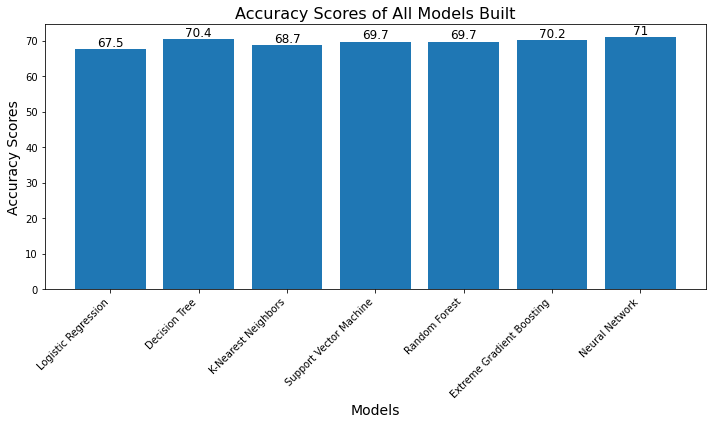

In [4]:
plt.figure(figsize=(10,6))
plt.bar(models, model_scores)
plt.xticks(rotation=45, fontsize=10, va='top', ha='right')
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy Scores', fontsize=14)
plt.title('Accuracy Scores of All Models Built', fontsize=16)
for i, score in enumerate(model_scores):
    plt.text(i, score, str(score), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

# Notebook Conclusion
In this notebook, we employed traditional Machine Learning models in order to predict our target variable. Among the traditional ML models that we employed, the highest score obtained was using a __decision__ tree algorithm. This model had a max depth of 8, a minimum samples per leaf of 1, and 16 principal components. 